# Importing Necessary Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Retrieving the data

In [8]:
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
#Selecting Random Data Samples from the Dataset of size 10000
parkingdata = parkingdata.sample(n=10000) 
parkingdata.size

130000

# Data Wrangling

In [9]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
6809574,REGENCY,EXHIBITION STREET,VICTORIA STREET,LA TROBE STREET,1,C7414,19/04/2012 12:39:08 PM,19/04/2012 01:17:07 PM,2279,2P TKT A M-SAT 7:30-20:30,0,647,3447
4383933,TITLES,QUEEN STREET,LA TROBE STREET,LT LONSDALE STREET,2,1286E,04/02/2012 05:33:58 PM,04/02/2012 05:35:50 PM,112,2P DIS M-SUN 0:00-23:59,0,1171,753
5401094,SOUTHBANK,COVENTRY STREET,STURT STREET,DODDS STREET,4,9443S,06/03/2012 11:46:13 AM,06/03/2012 01:13:02 PM,5209,1P TKT A M-F 7:30-18:30,1,547,4124
11425765,PRINCES THEATRE,SPRING STREET,LONSDALE STREET,LT BOURKE STREET,5,77W,06/09/2012 04:55:54 PM,06/09/2012 05:39:54 PM,2640,2P MTR M-SAT 7:30-20:30,0,1288,36
3305867,THE MAC,SWANSTON STREET,FRANKLIN STREET,LA TROBE STREET,5,4331W,03/01/2012 03:04:20 PM,03/01/2012 03:05:57 PM,97,1/2P MTR M-F 7:30-19:30,0,1329,3587


In [10]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [11]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

# Target field Identification and Feature Engineering

In [7]:
#Target field identification
target = parkingdata['In Violation?']
target.head(10)

4447547     0
11895396    0
2778075     0
8397268     1
7634789     1
2390428     0
4569898     0
4112828     0
4820511     0
3214378     1
Name: In Violation?, dtype: int64

In [8]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('In Violation?', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['Side Of Street'] = parkingdata['Side Of Street']
features['Duration of Parking Event (in seconds)'] = parkingdata['Duration of Parking Event (in seconds)']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,Side Of Street,Duration of Parking Event (in seconds),Street ID,Device ID,Arrival Hour,Departure Hour
4447547,0,0,0,0,0,4,2046,907,1291,9,10
11895396,1,1,1,1,1,2,248,1062,7417,18,18
2778075,2,2,2,2,2,3,1102,123,1361,11,12
8397268,3,3,3,3,3,3,2750,528,1322,13,14
7634789,4,4,4,2,4,1,46792,681,2998,7,20
2390428,5,5,5,4,5,4,386,547,4128,10,10
4569898,6,0,3,3,6,3,107,907,1297,12,12
4112828,7,4,6,5,0,3,249,681,2776,16,16
4820511,8,6,7,6,7,3,100,1381,3842,17,17
3214378,9,7,8,7,2,1,4256,1221,454,12,13


# Parameter tuning and Random Forest Data Modelling

In [9]:
#Parameter Tuning

#Define the parameters to tune and the values to tune to
params_randomforest = [
                { 
                   'n_estimators' : (10,20,30,50,70,90,100),
                    'criterion' : ('gini', 'entropy'),
                    'max_depth' : (3, 5, 7, 9, 10, 15),
                    'max_features' : ('auto', 'sqrt'),
                    'min_samples_split' : (2, 4, 6, 8, 10, 14, 16)
                    
                }
            ]

In [10]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_randomforest = GridSearchCV(RandomForestClassifier(), 
                      param_grid = params_randomforest, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [11]:
#Fit the model with the dataset
bestModel = gs_randomforest.fit(features, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  4.4min finished


In [12]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 70}

In [13]:
#Find the best values for the  parameters of the model (Formatted output)
best_e = bestModel.best_estimator_.get_params()['n_estimators']
best_C = bestModel.best_estimator_.get_params()['criterion']
best_maxd =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf =  bestModel.best_estimator_.get_params()['max_features']
best_mins =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimator:', best_e)
print('Best criterion:', best_C)
print('Best max depth:', best_maxd)
print('Best max features:', best_maxf)
print('Best min_samples_split:', best_mins)

Best estimator: 70
Best criterion: entropy
Best max depth: 15
Best max features: sqrt
Best min_samples_split: 4


In [14]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8978
1,gini,3,auto,2,20,0.9125
2,gini,3,auto,2,30,0.8911
3,gini,3,auto,2,50,0.8962
4,gini,3,auto,2,70,0.9092
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.9661
1172,entropy,15,sqrt,16,50,0.9670
1173,entropy,15,sqrt,16,70,0.9644
1174,entropy,15,sqrt,16,90,0.9654


In [15]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
randomforest = metric = RandomForestClassifier(n_estimators = best_e, 
                               criterion = best_C, 
                               max_depth = best_maxd, 
                               max_features = best_maxf,
                               min_samples_split = best_mins                
                               )

In [16]:
# Hill climbing w/ SVM
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = randomforest.fit(x_train, y_train)
    cur_Score = randomforest.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.8725
Score with 2 selected features: 0.929
Score with 3 selected features: 0.945
Score with 4 selected features: 0.9545
Score with 5 selected features: 0.96
Score with 6 selected features: 0.965

Indexs of the desired features
[2, 6, 0, 7, 8, 5]


In [17]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Duration of Parking Event (in seconds),Area Name,Street ID,Device ID,Side Of Street
4447547,0,2046,0,907,1291,4
11895396,1,248,1,1062,7417,2
2778075,2,1102,2,123,1361,3
8397268,3,2750,3,528,1322,3
7634789,4,46792,4,681,2998,1
2390428,5,386,5,547,4128,4
4569898,3,107,6,907,1297,3
4112828,6,249,7,681,2776,3
4820511,7,100,8,1381,3842,3
3214378,8,4256,9,1221,454,1


In [18]:
bestModel = gs_randomforest.fit(features_hc, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1412 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1862 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2412 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3062 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3812 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4662 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5612 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  4.1min finished


In [19]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [20]:
best_e_hc = bestModel.best_estimator_.get_params()['n_estimators']
best_C_hc = bestModel.best_estimator_.get_params()['criterion']
best_maxd_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf_hc =  bestModel.best_estimator_.get_params()['max_features']
best_mins_hc =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimators:', best_e_hc)
print('Best criterion:', best_C_hc)
print('Best max depth:', best_maxd_hc)
print('Best max features:', best_maxf_hc)
print('Best min_samples_split:', best_mins_hc)

Best estimators: 100
Best criterion: entropy
Best max depth: 15
Best max features: auto
Best min_samples_split: 2


In [21]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8960
1,gini,3,auto,2,20,0.9050
2,gini,3,auto,2,30,0.9026
3,gini,3,auto,2,50,0.9107
4,gini,3,auto,2,70,0.9130
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.9539
1172,entropy,15,sqrt,16,50,0.9552
1173,entropy,15,sqrt,16,70,0.9550
1174,entropy,15,sqrt,16,90,0.9552


In [22]:
randomforest = metric = RandomForestClassifier(n_estimators = best_e_hc, 
                               criterion = best_C_hc, 
                               max_depth = best_maxd_hc, 
                               max_features = best_maxf_hc,
                               min_samples_split = best_mins_hc                
                               )

# Classification report


 Accuracy score: 0.95480

 Misclassification Rate: 0.04520

 True Positive Rate: 0.77713

 True Negative Rate: 0.98329

 Precision : 0.88177

 Prevalence : 0.13820

 F score : 0.82615

 False Positive Rate: 0.01671


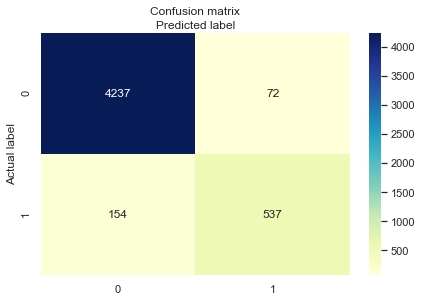

In [23]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
randomforest.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = randomforest.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(randomforest.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

# ROC Curve

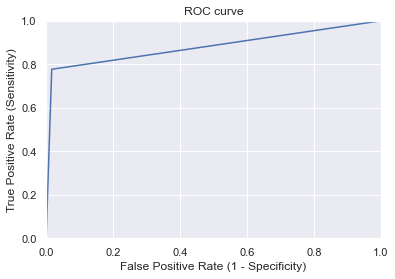

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predicted)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# K-folds mean score

In [25]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    randomforest.fit(x_train, y_train)
    kFoldTotal += randomforest.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, randomforest.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nRandom Forest mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.96050
[fold 1] score: 0.95600
[fold 2] score: 0.96050
[fold 3] score: 0.96100
[fold 4] score: 0.95500

Random Forest mean score [5 folds] = 0.9586
